***
# **SM Labs - TimeSeries Analyzer - Datasets Triple Collocation** 

In the laboratory of **sm time-series** we will perform the following points:
   * Configure the libraries and the dependecies of the laboratory;
   * Configure the datasets (select the name of the point registry);
   * Analyze the datasets (for different seasons and different scaling methods);
   * View and dump the metrics;
   * Plot and dump the figure(s); 

### **Import libraries and dependencies**

In [1]:
%matplotlib inline
%matplotlib widget

# Libraries
import logging
import time
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy
from scipy import stats

import pytesmo.scaling as scaling
import pytesmo.metrics as metrics
from pytesmo.time_series.filters import exp_filter, boxcar_filter

from lib_notebook_io_json import read_time_series_product, read_time_series_datasets
from lib_notebook_io_generic import read_file_json
from lib_notebook_geo import read_point_data
from lib_notebook_system import fill_tags2string, make_folder

import matplotlib.pylab as plt

# logging
logging.getLogger("fiona").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("pandas").setLevel(logging.WARNING)

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import HTML, display

# Info
print(' ==> Libraries loaded')

 ==> Libraries loaded


In [2]:
# method to set cell background
def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)
    
    display(HTML('<img src onerror="{}" style="display:none">'.format(script)))
    
# Info
print(' ==> Methods loaded')

 ==> Methods loaded


In [13]:
# Define the configuration file
folder_name_settings = os.getcwd()
file_name_settings = 'notebook_recolour_sm_ts_hmc_datasets_tc.json'
#file_name_settings = 'notebook_recolour_sm_ts_ecmwf.json'
file_path_settings = os.path.join(folder_name_settings, file_name_settings)

flag_exp_filter = True

# define label of obs and mod datasets
label_obs = 'sm_obs'
label_tc = 'sm_tc'
label_ecmwf_l1 = 'sm_ecmwf_layer_0_7'
label_ecmwf_l2 = 'sm_ecmwf_layer_0_28'
label_ecmwf_l3 = 'sm_ecmwf_layer_0_100'
label_hmc = 'sm_hmc'
label_smap = 'sm_smap'

# Info
print(' ==> Define the datasets tags')

# set the configuration file
if os.path.exists(file_path_settings):
    data_settings = read_file_json(file_name_settings)
else:
    print(' ===> File "' + file_path_settings + '" not found')
    raise FileNotFound('File not found')
# Info
print(' ==> Define the configuration file name: "' + file_path_settings + '"')

 ==> Define the datasets tags
 ==> Define the configuration file name: "/home/fabio/Documents/Work_Area/Code_Development/Workspace/Recolour_Workspace/recolour-notebook/notebook_recolour_sm_ts_hmc_datasets_tc.json"


In [4]:
# get configuration object(s)
obj_parameters = data_settings['parameters']
obj_template = data_settings['template']
obj_data = data_settings['data']
obj_figure = data_settings['figure']
obj_metrics = data_settings['metrics']
# Info
print(' ==> Set the configuration objects')

 ==> Set the configuration objects


### **Configure the datasets**
#### Set the registry datasets

In [5]:
# Define the registry folder name and the file name
folder_name_registry = obj_data['registry']['folder_name']
file_name_registry = obj_data['registry']['file_name']
file_path_registry = os.path.join(folder_name_registry, file_name_registry)

# Info
print(' ==> Define the registry file name: "' + file_path_registry + '" ... DONE')

 ==> Define the registry file name: "/home/fabio/Desktop/Recolour_Workspace/recolour-ws/weather_stations_dr/destination/data_static/sm_ws_registry_only_valid_v3.csv" ... DONE


In [6]:
# get registry data
registry_dframe = read_point_data(file_path_registry)
registry_name_info, registry_tag_info = list(registry_dframe['name']), list(registry_dframe['tag'])

print(registry_dframe.head(5))
# Info
print(' ==> Load the registry file name ... DONE')

 ===> Column "units" is not available in the source registry
 ===> Column "locations" is not available in the source registry
   longitude                   amm_level_1                       name  valid  \
3    13.9150                       ABRUZZO                Penne, Diga      1   
4    14.4545                       ABRUZZO  Castiglione Messer Marino      1   
5    12.1592                        Umbria                   Petrelle      1   
7    12.2317                        Umbria                    Cerbara      1   
8     6.9636  Valle d'Aosta/Vallée d'Aoste                  La Thuile      1   

  amm_level_2  altitude units  code  latitude location            tag  \
3          PE       260     %  1122   42.4401       NA      DigaPenne   
4          CH       975     %  1123   41.8696       NA  CastiglioneMM   
5          PG       294     %  2316   43.3475       NA       Petrelle   
7          PG       321     %  2762   43.5081       NA        Cerbara   
8          AO      1732     

In [7]:
# Display available outlet sections
registry_obj_select = widgets.Dropdown(options=registry_tag_info, description='Point', disabled=False, rows=5)
display(registry_obj_select) 
# set color
set_background('#90ee90')

Dropdown(description='Point', options=('DigaPenne', 'CastiglioneMM', 'Petrelle', 'Cerbara', 'LaThuile', 'Toran…

##### NOTE: Pizzoli, CogneV, LaThuile ---> Problemi con il dato modellato 

In [8]:
# Parser the selection from the scroll menu
registry_tag_value = str(registry_obj_select.value)

# Info
print(' ==> Select the registry name "' + registry_tag_value + '" ... DONE')

 ==> Select the registry name "DigaPenne" ... DONE


In [9]:
# select point
#param_name = obj_parameters['point_name']
registry_point = registry_dframe.loc[registry_dframe['tag'] == registry_tag_value]
registry_dict = registry_point.to_dict('records')[0]

# Info
print(' ==> Select the registry info ... DONE')

 ==> Select the registry info ... DONE


### **Configure the source datasets**

#### Set the time-series source datasets

In [10]:
# get time-series info
folder_name_ts = obj_data['time_series']['folder_name']
file_name_ts = obj_data['time_series']['file_name']
file_path_ts_template = os.path.join(folder_name_ts, file_name_ts)

obj_values_ts = {'point_name': registry_tag_value}
file_path_ts_point = fill_tags2string(file_path_ts_template, obj_template, obj_values_ts)[0]

# Info
print(' ==> Define the datasets file name: "' + file_path_ts_point + '" ... DONE')

 ==> Define the datasets file name: "/home/fabio/Desktop/Recolour_Workspace/recolour-ws/ts_analysis/destination/hmc/v3/sm_ts_20150101_20230701_DigaPenne_d6.json" ... DONE


In [11]:
# get time-series data product
ts_dframe_product, ts_dframe_obs, ts_dframe_tc = read_time_series_product(file_path_ts_point)

# Info
print(ts_dframe_product.head(5))
print(' ==> Load the time-series product ... DONE')

            sm_obs  sm_tc season
2018-10-15     9.0   48.5    SON
2018-10-16     9.0   56.5    SON
2018-10-17     9.0   49.6    SON
2018-10-18     9.0   50.2    SON
2018-10-19     9.0   59.4    SON
 ==> Load the time-series product ... DONE


In [12]:
# get time-series data datasets
(ts_dframe_datasets, 
 ts_dframe_ecmwf_l1, ts_dframe_ecmwf_l2, ts_dframe_ecmwf_l3, 
 ts_dframe_hmc, ts_dframe_smap) = read_time_series_datasets(file_path_ts_point)

# Info
print(ts_dframe_datasets.head(5))
print(' ==> Load the time-series product ... DONE')

            sm_ecmwf_layer_0_7  sm_ecmwf_layer_0_28  sm_ecmwf_layer_0_100  \
2016-02-01                51.8                 46.4                  48.7   
2016-02-02                57.4                 47.8                  49.2   
2016-02-03                47.2                 45.1                  48.6   
2016-02-04                47.7                 45.5                  48.9   
2016-02-05                47.6                 45.6                  48.9   

            sm_hmc  sm_smap season  
2016-02-01    75.9    25.30    DJF  
2016-02-02    74.9    26.25    DJF  
2016-02-03    73.5    23.05    DJF  
2016-02-04    77.9    24.58    DJF  
2016-02-05    77.4    27.80    DJF  
 ==> Load the time-series product ... DONE


#### Apply filter(s) to the time-series source

In [14]:
# apply filter to observed ts
ts_obs = ts_dframe_obs[[label_obs]].dropna()

# Get julian dates of time series
jd = ts_obs.index.to_julian_date().values

# Apply filter(s) to check time-series
ts_dframe_obs[label_obs + '_t02_ef'] = exp_filter(ts_obs[label_obs].values, jd, ctime=2)
ts_dframe_obs[label_obs + '_t02_bc'] = boxcar_filter(ts_obs[label_obs].values, jd, window=2)

In [27]:
# apply filter to triple collocation ts
ts_tc = ts_dframe_tc[[label_tc]].dropna()

# Get julian dates of time series
jd = ts_tc.index.to_julian_date().values

# Apply filter(s) to check time-series
ts_dframe_tc[label_tc + '_t02_ef'] = exp_filter(ts_tc[label_tc].values, jd, ctime=2)
ts_dframe_tc[label_tc + '_t02_bc'] = boxcar_filter(ts_tc[label_tc].values, jd, window=2)

In [28]:
# apply filter to ecmwf l1 ts
ts_ecmwf_l1 = ts_dframe_ecmwf_l1[[label_ecmwf_l1]].dropna()

# Get julian dates of time series
jd = ts_ecmwf_l1.index.to_julian_date().values

# Apply filter(s) to check time-series
ts_dframe_ecmwf_l1[label_ecmwf_l1 + '_t02_ef'] = exp_filter(ts_ecmwf_l1[label_ecmwf_l1].values, jd, ctime=2)
ts_dframe_ecmwf_l1[label_ecmwf_l1 + '_t02_bc'] = boxcar_filter(ts_ecmwf_l1[label_ecmwf_l1].values, jd, window=2)

In [29]:
# apply filter to ecmwf l2 ts
ts_ecmwf_l2 = ts_dframe_ecmwf_l2[[label_ecmwf_l2]].dropna()

# Get julian dates of time series
jd = ts_ecmwf_l2.index.to_julian_date().values

# Apply filter(s) to check time-series
ts_dframe_ecmwf_l2[label_ecmwf_l2 + '_t02_ef'] = exp_filter(ts_ecmwf_l2[label_ecmwf_l2].values, jd, ctime=2)
ts_dframe_ecmwf_l2[label_ecmwf_l2 + '_t02_bc'] = boxcar_filter(ts_ecmwf_l2[label_ecmwf_l2].values, jd, window=2)

In [30]:
# apply filter to ecmwf l3 ts
ts_ecmwf_l3 = ts_dframe_ecmwf_l3[[label_ecmwf_l3]].dropna()

# Get julian dates of time series
jd = ts_ecmwf_l3.index.to_julian_date().values

# Apply filter(s) to check time-series
ts_dframe_ecmwf_l3[label_ecmwf_l3 + '_t02_ef'] = exp_filter(ts_ecmwf_l3[label_ecmwf_l3].values, jd, ctime=2)
ts_dframe_ecmwf_l3[label_ecmwf_l3 + '_t02_bc'] = boxcar_filter(ts_ecmwf_l3[label_ecmwf_l3].values, jd, window=2)

In [31]:
# apply filter to hmc
ts_hmc = ts_dframe_hmc[[label_hmc]].dropna()

# Get julian dates of time series
jd = ts_hmc.index.to_julian_date().values

# Apply filter(s) to check time-series
ts_dframe_hmc[label_hmc + '_t02_ef'] = exp_filter(ts_hmc[label_hmc].values, jd, ctime=2)
ts_dframe_hmc[label_hmc + '_t02_bc'] = boxcar_filter(ts_hmc[label_hmc].values, jd, window=2)

In [32]:
# apply filter to smap
ts_smap = ts_dframe_smap[[label_smap]].dropna()

# Get julian dates of time series
jd = ts_smap.index.to_julian_date().values

# Apply filter(s) to check time-series
ts_dframe_smap[label_smap + '_t02_ef'] = exp_filter(ts_smap[label_smap].values, jd, ctime=2)
ts_dframe_smap[label_smap + '_t02_bc'] = boxcar_filter(ts_smap[label_smap].values, jd, window=2)

#### Define the folder(s) and the filename(s) of figure(s) and metrics

In [33]:
# get figure info
folder_name_figure = obj_figure['folder_name']
file_name_figure = obj_figure['file_name']
file_path_figure_template = os.path.join(folder_name_figure, file_name_figure)

In [34]:
# set metrics info
folder_name_metrics = obj_metrics['folder_name']
file_name_metrics = obj_metrics['file_name']
file_path_metrics_template = os.path.join(folder_name_metrics, file_name_metrics)

### **Plot the source datasets**

#### Plot the time-series

In [44]:
info_graph_value = 'ts_obs'
file_dpi_image = 150

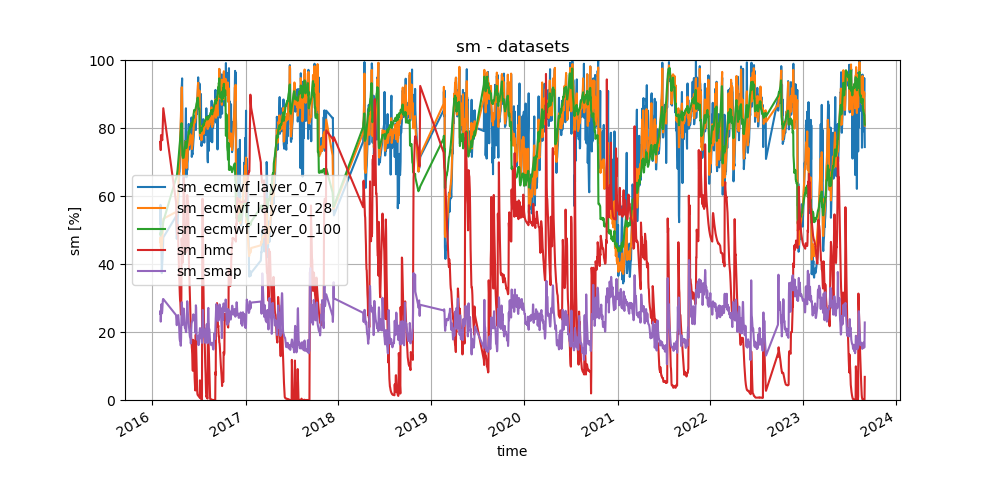

 ==> Plot the time-series figure ... DONE


In [47]:
# Plot the datasets
fig, ax = plt.subplots()

ts_dframe_datasets.plot(figsize=(10, 5), ax=ax) #, color='blue')
ax.set_xlabel('time')
ax.set_ylabel('sm [%]')
#ax.legend(["sm observed"])
ax.grid(True)

plt.ylim(0, 100)
plt.title('sm - datasets')
plt.show()

# Info
print(' ==> Plot the time-series figure ... DONE')

### **Plot the product datasets**

#### Plot the time-series

In [48]:
info_graph_value = 'ts_obs'
file_dpi_image = 150

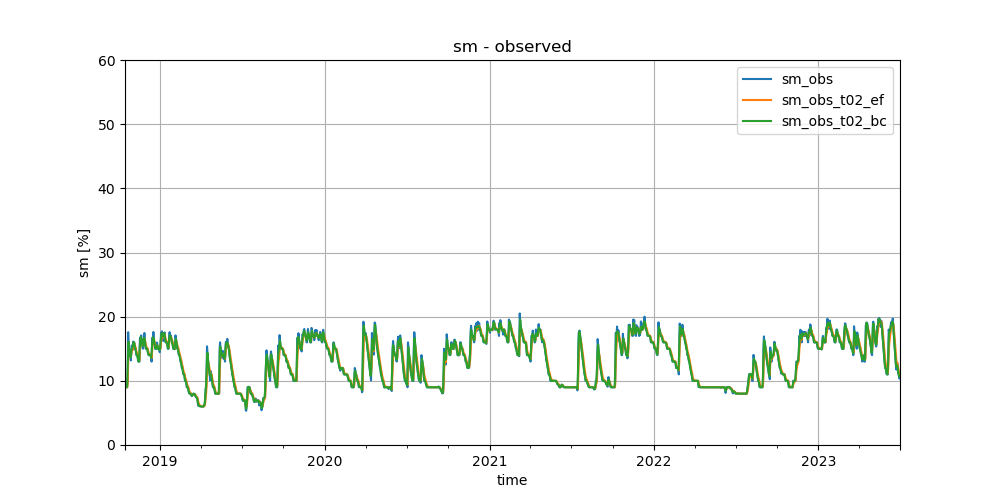

 ==> Plot the time-series figure ... DONE


In [49]:
# Plot the datasets
fig, ax = plt.subplots()

ts_dframe_obs.plot(figsize=(10, 5), ax=ax) #, color='blue')
ax.set_xlabel('time')
ax.set_ylabel('sm [%]')
#ax.legend(["sm observed"])
ax.grid(True)

plt.ylim(0, 60)
plt.title('sm - observed')
plt.show()

# Info
print(' ==> Plot the time-series figure ... DONE')

In [37]:
# Create plot name
obj_values_figure = {'graph_name': info_graph_value, 'point_name': registry_tag_value, 'season_name': 'ALL'}
file_path_figure_obs = fill_tags2string(file_path_figure_template, obj_template, obj_values_figure)[0]

# Join the folder and the file name(s)
folder_name_figure_obs, file_name_figure_obs = os.path.split(file_path_figure_obs)

# Make the image folder
if not os.path.exists(folder_name_figure_obs):
    os.makedirs(folder_name_figure_obs, exist_ok=True)

# Info
print(' ==> Define the figure filename "' + file_path_figure_obs + '" ... DONE')

 ==> Define the figure filename "/home/fabio/Desktop/Recolour_Workspace/recolour-ws/ts_analysis/figure/hmc/v3/sm_ts_20150101_20230701_DigaPenne_ts_obs_ALL.jpeg" ... DONE


In [38]:
# Dump the plot
fig.savefig(file_path_figure_obs, dpi=file_dpi_image)

# Info
print(' ==> Dump the figure filename ... DONE')

 ==> Dump the figure filename ... DONE


#### Plot the time-series

In [1623]:
info_graph_value = 'ts_tc'
file_dpi_image = 150

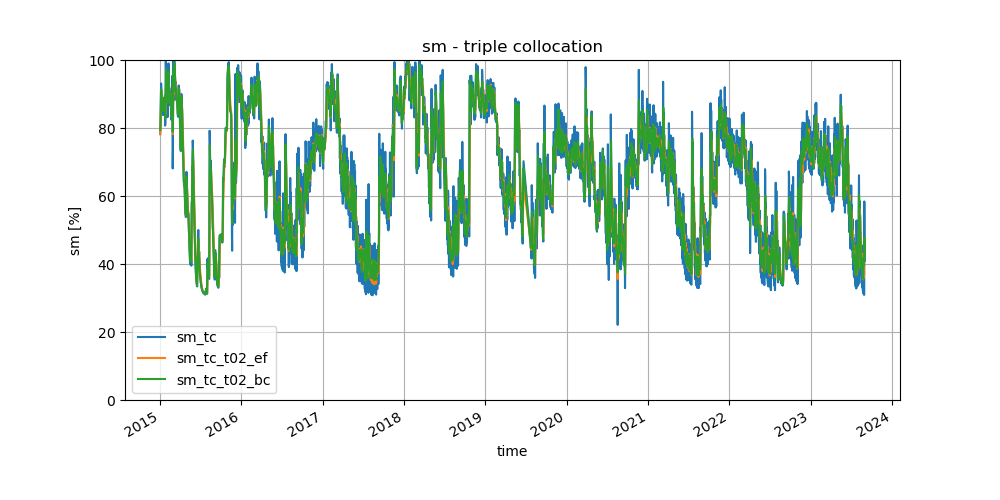

 ==> Plot the time-series figure ... DONE


In [40]:
# Plot the datasets
fig, ax = plt.subplots()

ts_dframe_tc.plot(figsize=(10, 5), ax=ax) #, color='red')
ax.set_xlabel('time')
ax.set_ylabel('sm [%]')
#ax.legend(["sm modellled"])
ax.grid(True)

plt.ylim(0, 100)
plt.title('sm - triple collocation')
plt.show()

# Info
print(' ==> Plot the time-series figure ... DONE')

In [41]:
# Create plot name
obj_values_figure = {'graph_name': info_graph_value, 'point_name': registry_tag_value, 'season_name': 'ALL'}
file_path_figure_mod = fill_tags2string(file_path_figure_template, obj_template, obj_values_figure)[0]

# Join the folder and the file name(s)
folder_name_figure_mod, file_name_figure_mod = os.path.split(file_path_figure_mod)

# Make the image folder
if not os.path.exists(folder_name_figure_mod):
    os.makedirs(folder_name_figure_mod, exist_ok=True)

# Info
print(' ==> Define the figure filename "' + file_path_figure_mod + '" ... DONE')

 ==> Define the figure filename "/home/fabio/Desktop/Recolour_Workspace/recolour-ws/ts_analysis/figure/hmc/v3/sm_ts_20150101_20230701_DigaPenne_ts_obs_ALL.jpeg" ... DONE


In [42]:
# Dump the plot
fig.savefig(file_path_figure_mod, dpi=file_dpi_image)

# Info
print(' ==> Dump the figure filename ... DONE')

 ==> Dump the figure filename ... DONE


### **Analyze the processed datasets**

In [43]:
# apply filter to modelled ts
ts_tc = ts_dframe_product[[label_tc]].dropna()

# Get julian dates of time series
jd = ts_tc.index.to_julian_date().values
# filter(s)
ts_dframe_product[label_mod] = boxcar_filter(ts_tc[label_mod].values, jd, window=2) # ortucchio 5 cogne 10

# set color
set_background('honeydew')

In [1628]:
# apply filter to observed ts
ts_obs = ts_dframe_complete[[label_obs]].dropna()

# Get julian dates of time series
jd = ts_obs.index.to_julian_date().values
# filter(s)
#ts_dframe_complete[label_obs] = exp_filter(ts_obs[label_obs].values, jd, ctime=1)
ts_dframe_complete[label_obs] = boxcar_filter(ts_obs[label_obs].values, jd, window=1) # 

# Info
print(ts_dframe_complete.head(5))
print(' ==> Load the time-series file name ... DONE')

# set color
set_background('honeydew')

            sm_obs      sm_tc season
2018-10-15   22.00  51.400000    SON
2018-10-16   21.00  50.066667    SON
2018-10-17   21.00  50.800000    SON
2018-10-18   20.58  49.900000    SON
2018-10-19   20.00  49.333333    SON
 ==> Load the time-series file name ... DONE


#### Seasonal datasets

In [1629]:
# Load the seasons
info_season_list = list(ts_dframe_complete['season'].values)
info_season_list = sorted(list(set(info_season_list + ['ALL'])))

info_season_ext = ['MAM,SON', 'MAM,JJA', 'JJA,SON', 'MAM,JJA,SON']
info_season_list = info_season_list + info_season_ext

info_season_n = info_season_list.__len__()

# Info
print(info_season_list)
print(' ==> Select seasons ... DONE')

['ALL', 'DJF', 'JJA', 'MAM', 'SON', 'MAM,SON', 'MAM,JJA', 'JJA,SON', 'MAM,JJA,SON']
 ==> Select seasons ... DONE


In [1630]:
# Display available outlet sections
info_season_select = widgets.Dropdown(options=info_season_list, description='Season', disabled=False, rows=info_season_n)
display(info_season_select) 
# set color
set_background('#90ee90')

Dropdown(description='Season', options=('ALL', 'DJF', 'JJA', 'MAM', 'SON', 'MAM,SON', 'MAM,JJA', 'JJA,SON', 'M…

In [1631]:
# Parser the selection from the scroll menu
info_season_value = str(info_season_select.value)
info_season_string = info_season_value.replace(',','_')

info_season_value = info_season_value.split(',')

# Info
print(' ==> Select the season name "' + str(info_season_value) + '" ... DONE')

 ==> Select the season name "['ALL']" ... DONE


In [1632]:
# Get the seasonal dframe
if info_season_value == ['ALL']:
    ts_dframe_filtered = deepcopy(ts_dframe_complete)
else:
    #ts_dframe_filtered = ts_dframe_complete.loc[ts_dframe_complete['season'] == info_season_value]
    ts_dframe_filtered = ts_dframe_complete[ts_dframe_complete['season'].isin(info_season_value)]
    
# Info
print(ts_dframe_complete.head(5))
print(ts_dframe_filtered.head(5))
print(' ==> Select the season datasets ... DONE')

            sm_obs      sm_tc season
2018-10-15   22.00  51.400000    SON
2018-10-16   21.00  50.066667    SON
2018-10-17   21.00  50.800000    SON
2018-10-18   20.58  49.900000    SON
2018-10-19   20.00  49.333333    SON
            sm_obs      sm_tc season
2018-10-15   22.00  51.400000    SON
2018-10-16   21.00  50.066667    SON
2018-10-17   21.00  50.800000    SON
2018-10-18   20.58  49.900000    SON
2018-10-19   20.00  49.333333    SON
 ==> Select the season datasets ... DONE


In [1633]:
# Drop the seasonal column
ts_dframe_filtered = ts_dframe_filtered.drop(columns=['season'])

# Info
print(ts_dframe_filtered.head(5))
print(' ==> Select the season datasets ... DONE')

            sm_obs      sm_tc
2018-10-15   22.00  51.400000
2018-10-16   21.00  50.066667
2018-10-17   21.00  50.800000
2018-10-18   20.58  49.900000
2018-10-19   20.00  49.333333
 ==> Select the season datasets ... DONE


#### Filtering datasets by dates

In [1634]:
# Filter datasets accordign with periods, errors and outliers in the original time-series 

# ortucchio riduzione dataset
#ts_dframe_filtered = ts_dframe_filtered['2015-01-01':'2022-04-01']

# cogne riduzione dataset
#ts_dframe_filtered = ts_dframe_filtered['2020-04-01':'2023-03-01']
#ts_dframe_filtered['2023-03-01':'2023-05-01'] = np.nan
#ts_dframe_filtered = ts_dframe_filtered.dropna()

# canistro riduzione dataset
#ts_dframe_filtered['2020-04-01':'2022-03-01'] = np.nan
#ts_dframe_filtered = ts_dframe_filtered.dropna()

# torano riduzione dataset
#ts_dframe_filtered[ts_dframe_filtered[label_obs] > 5] = np.nan
#ts_dframe_filtered = ts_dframe_filtered.dropna()

# satriano riduzione dataset
#ts_dframe_filtered[ts_dframe_filtered[label_obs] > 5] = np.nan
#ts_dframe_filtered = ts_dframe_filtered.dropna()

# chiaravalle riduzione dataset
#ts_dframe_filtered[ts_dframe_filtered[label_obs] > 4] = np.nan
#ts_dframe_filtered = ts_dframe_filtered.dropna()

# torre olmo riduzione dataset
#ts_dframe_filtered[ts_dframe_filtered[label_obs] < 20] = np.nan
#ts_dframe_filtered = ts_dframe_filtered.dropna()
#ts_dframe_filtered['2021-11-01':'2021-11-15'] = np.nan
#ts_dframe_filtered = ts_dframe_filtered.dropna()

# ovindoli riduzione dataset -- selezionare stagioni MAM-JJA-SON
#ts_dframe_filtered['2022-01-15':'2022-03-15'] = np.nan
#ts_dframe_filtered = ts_dframe_filtered.dropna()

# aquila_campoimperatore riduzione dataset -- selezionare stagioni JJA-SON

# rocca san giovanni riduzione dataset
#ts_dframe_filtered = ts_dframe_filtered['2020-01-01':'2022-07-01']

# Info
print(ts_dframe_filtered.head(5))
print(' ==> Select the filtered datasets ... DONE')

# set color
set_background('honeydew')

            sm_obs      sm_tc
2018-10-15   22.00  51.400000
2018-10-16   21.00  50.066667
2018-10-17   21.00  50.800000
2018-10-18   20.58  49.900000
2018-10-19   20.00  49.333333
 ==> Select the filtered datasets ... DONE


#### Scale datasets

In [1635]:
# Scale datasets using a method defined in pytestmo library
ts_dframe_scaled = scaling.scale(ts_dframe_filtered, method='cdf_beta_match', reference_index=0)

# Info
print(' ==> Scale the datasets ... DONE')

# set color
set_background('honeydew')

 ==> Scale the datasets ... DONE


/home/fabio/Desktop/Documents/Work_Area/Code_Development/Workspace/Recolour_Workspace/conda/envs/recolour_notebook_libraries/lib/python3.7/site-packages/pytesmo/utils.py:432: UserWarning: The bins have been resized
  warnings.warn("The bins have been resized")


#### Compute metrics

In [1636]:
# Set the name of the plot
info_graph_value = 'metrics_scaled'

In [1637]:
# Calculate correlation coefficients, RMSD, bias, Nash Sutcliffe
x, y = ts_dframe_scaled[label_obs].values, ts_dframe_scaled[label_mod].values

metrics_list = []
metrics_list.append("Pearson's R    = {:.2f}, p = {:.2e}".format(*stats.pearsonr(x, y)))
metrics_list.append("Spearman's rho = {:.2f}, p = {:.2e}".format(*stats.spearmanr(x, y)))
metrics_list.append("Kendall's tau  = {:.2f}, p = {:.2e}".format(*stats.kendalltau(x, y)))
metrics_list.append('')
metrics_list.append("RMSD = {:.2f}".format(metrics.rmsd(x, y)))
metrics_list.append("Bias = {:.2f}".format(metrics.bias(x, y)))
metrics_list.append("Nash Sutcliffe = {:.2f}".format(metrics.nash_sutcliffe(x, y)))

# Info
print(' ==> Compute the metrics ... DONE')

 ==> Compute the metrics ... DONE


In [1638]:
# View the computed metrics
for metrics_step in metrics_list:
    print(' ===> ' + metrics_step)

# Info
print(' ==> View the metrics ... DONE')

 ===> Pearson's R    = 0.87, p = 0.00e+00
 ===> Spearman's rho = 0.85, p = 0.00e+00
 ===> Kendall's tau  = 0.66, p = 0.00e+00
 ===> 
 ===> RMSD = 1.71
 ===> Bias = -0.00
 ===> Nash Sutcliffe = 0.74
 ==> View the metrics ... DONE


In [1639]:
# Create metrics name
obj_values_figure = {'graph_name': info_graph_value, 'point_name': registry_tag_value, 'season_name': info_season_string}
file_path_metrics = fill_tags2string(file_path_metrics_template, obj_template, obj_values_figure)[0]

# Join the folder and the file name(s)
folder_name_metrics, file_name_metrics = os.path.split(file_path_metrics)

# Make the image folder
if not os.path.exists(folder_name_metrics):
    os.makedirs(folder_name_metrics, exist_ok=True)
    
# Info
print(' ==> Define the metrics file name "' + file_path_metrics + '" ... DONE')

 ==> Define the metrics file name "/home/fabio/Desktop/Recolour_Workspace/recolour-ws/ts_analysis/metrics/hmc/v3/sm_ts_20150101_20230701_Guilmi_metrics_ALL.txt" ... DONE


In [1640]:
# Dump the metrics to the file
with open(file_path_metrics, 'a') as file_handle:
    for metrics_step in metrics_list: 
        file_handle.write(metrics_step + '\n')

# Info
print(' ==> Dump the metrics data ... DONE')

 ==> Dump the metrics data ... DONE


### **Plot the scaled datasets**

#### Plot the time-series

In [1641]:
# Set the name of the plot
info_graph_value = 'ts_scaled'
file_dpi_image = 150

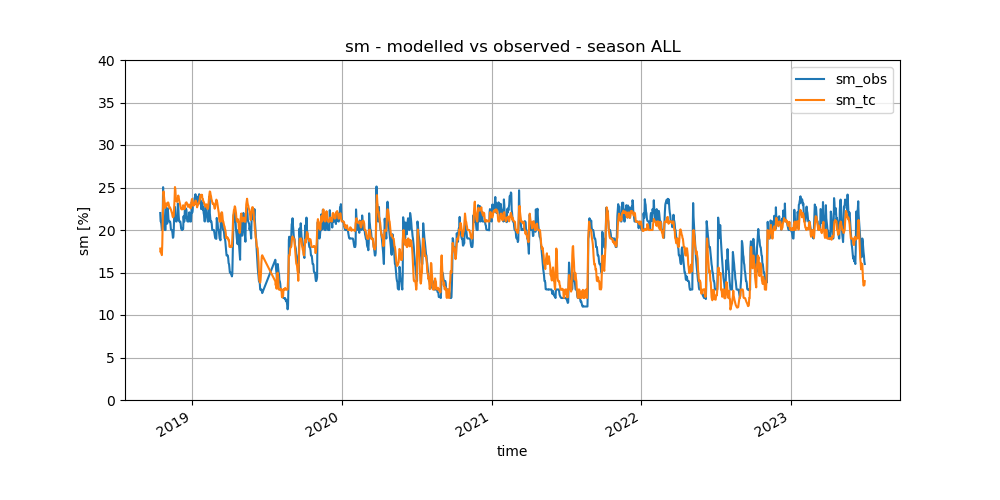

 ==> Plot the time-series figure ... DONE


In [1642]:
# Plot the datasets
fig, ax = plt.subplots()

ts_dframe_scaled.plot(figsize=(10, 5), ax=ax)
#plt.plot(ts_dframe_scaled.index.to_pydatetime(), ts_dframe_scaled, 'o-')

ax.set_xlabel('time')
ax.set_ylabel('sm [%]')

#ax.legend(["sm modelled", "sm observed"])
ax.grid(True)

plt.ylim(0, 40)
plt.title('sm - modelled vs observed - season ' + info_season_string)
plt.show()

# Info
print(' ==> Plot the time-series figure ... DONE')

In [1643]:
# Create plot name
obj_values_figure = {'graph_name': info_graph_value, 'point_name': registry_tag_value, 'season_name': info_season_string}
file_path_figure_scaled = fill_tags2string(file_path_figure_template, obj_template, obj_values_figure)[0]

# Join the folder and the file name(s)
folder_name_figure_scaled, file_name_figure_scaled = os.path.split(file_path_figure_scaled)

# Make the image folder
if not os.path.exists(folder_name_figure_scaled):
    os.makedirs(folder_name_figure_scaled, exist_ok=True)

# Info
print(' ==> Define the time-series file name "' + file_path_figure_scaled + '" ... DONE')

 ==> Define the time-series file name "/home/fabio/Desktop/Recolour_Workspace/recolour-ws/ts_analysis/figure/hmc/v3/sm_ts_20150101_20230701_Guilmi_ts_scaled_ALL.jpeg" ... DONE


In [1644]:
# Dump the plot
fig.savefig(file_path_figure_scaled, dpi=file_dpi_image)

# Info
print(' ==> Dump the time-series figure ... DONE')

 ==> Dump the time-series figure ... DONE


#### Plot the scatter

In [1645]:
# Set the name of the plot
info_graph_value = 'scatter_scaled'
file_dpi_image = 150

/home/fabio/Desktop/Documents/Work_Area/Code_Development/Workspace/Recolour_Workspace/conda/envs/recolour_notebook_libraries/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


 ==> Plot the scatter figure ... DONE


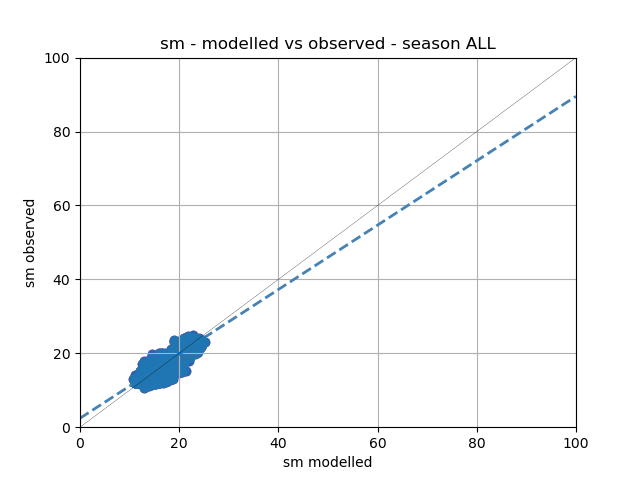

In [1646]:
# Plot the datasets
fig, ax = plt.subplots()

ax.scatter(ts_dframe_scaled[label_obs].values, ts_dframe_scaled[label_mod].values, color='purple')
ax.set_xlabel('sm modelled')
ax.set_ylabel('sm observed')
ax.grid(True)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(ts_dframe_scaled[label_obs].values, ts_dframe_scaled[label_mod].values, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 100, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, lw=2.5, color='steelblue', linestyle='--', linewidth=2);

sns.regplot(x=ts_dframe_scaled[label_obs].values, y=ts_dframe_scaled[label_mod].values)

ax.plot([0, 25, 50, 75, 100], [0, 25, 50, 75, 100], color='k', linestyle='-', linewidth=0.2)

plt.ylim(0, 100);
plt.xlim(0, 100);
plt.title('sm - modelled vs observed - season ' + info_season_string)

# Info
print(' ==> Plot the scatter figure ... DONE')

In [1647]:
# Create plot name
obj_values_figure = {'graph_name': info_graph_value, 'point_name': registry_tag_value, 'season_name': info_season_string}
file_path_figure_scatter = fill_tags2string(file_path_figure_template, obj_template, obj_values_figure)[0]

# Join the folder and the file name(s)
folder_name_figure_scatter, file_name_figure_scatter = os.path.split(file_path_figure_scatter)

# Make the image folder
if not os.path.exists(folder_name_figure_scatter):
    os.makedirs(folder_name_figure_scatter, exist_ok=True)

# Info
print(' ==> Define the scatter file name "' + file_path_figure_scatter + '" ... DONE')

 ==> Define the scatter file name "/home/fabio/Desktop/Recolour_Workspace/recolour-ws/ts_analysis/figure/hmc/v3/sm_ts_20150101_20230701_Guilmi_scatter_scaled_ALL.jpeg" ... DONE


In [1648]:
# Dump the plot
fig.savefig(file_path_figure_scatter, dpi=file_dpi_image)

# Info
print(' ==> Dump the scatter figure ... DONE')

 ==> Dump the scatter figure ... DONE


**Training on-the-job**
- Download/Organize analysis for a different datasets;
- Organize analysis for a different "point";
- Organize analysis using another scaling method;
- Organize analysis using a season of the year;
- ...